In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import os
from pathlib import Path
import pickle

In [26]:
FIBER = "Draka_GRIN"
# FIBER = "TL_GRIN"
DATA_PATH = Path("../Data") / FIBER
# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    return DATA_PATH / file_name


def image_path(file_name):
    full_path = str(IMAGE_FOLDER / file_name)
    print(f">> image path: {full_path}")
    return full_path

In [27]:
REF_SIZE = 24
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6
FIGSIZE = (8, 5)
SAVE_FIG = True

# I. Load data


## A. Load parameters


### A.1 Load data from files


In [28]:
# data generated by `Experiment_VS_Model.ipynb``
DATA_FILE = DATA_PATH / "processed_data.pkl"
qs = (0, 1, 2, 3)
deformations2show = [0, 2, 3, 4]

# load pickle
with open(DATA_FILE, "rb") as f:
    data = pickle.load(f)

In [29]:
# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# deformation values
Delta_x = param["Delta_x"]

In [31]:
with open(file_path("param.pkl"), "rb") as file:
    param_big = pickle.load(file, encoding="latin1")

dict_keys(['modes', 'exp'])

### A.2 Fiber parameters


In [23]:
# Physical parameters
L_tot = data["theo"]["L_tot"]
radius = data["theo"]["radius"]
d_layer = data["theo"]["d_layer"]
dz = data["theo"]["dz"]
# std_max = data["theo"]["std_max"]

wl = param_big["fiber"]["wl"]
NA = param_big["fiber"]["NA"]
n1 = param_big["fiber"]["n1"]

std_max = 1/radius*NA**2/n1*d_layer

k0 = 2.0 * np.pi / wl
# difference of refractive index between the axis (maximum value) and the cladding (minimum value)
Dn = NA**2 / (2.0 * n1)

# Mode parameters
nmodes = data["modes"]["nmodes"]
betas = data["modes"]["betas"]
M = data["theo"]["M_norm"]  # mode matrix
m = data["modes"]["m"]
deltaM = data["modes"]["deltaM"]
l = data["modes"]["l"]
deltaBeta = data["modes"]["deltaBeta"]

KeyError: 'theo'

### A.3 Theory parameters


In [ ]:
# number of segments to consider
Nz = data["theo"]["Nz"]
# Nz = L_tot / dz

# range and discretization parameters for the numerical estimation
# of the terms of Eq.X
dr = data["theo"]["dr"]
r_max = data["theo"]["r_max"]

## B. Load results


### B.1 Load numerical and experimental correlation results


In [ ]:
Corr_seg_mean = data["simu"]["Corr_mean"]
Corr_seg_std = data["simu"]["Corr_std"]
Corr_theory_0 = data["theo"]["Corr_mean"]
Corr_mean_exp = data["exp"]["Corr_mean"]
Corr_std_exp = data["exp"]["Corr_std"]

### B.2 Load theory fit parameters


In [ ]:
# fitted values for the deformation parameters ($\Gamma_q$ in the paper)
gammas = data["theo"]["gammas"]
# angles values for the angular correlation (same as in experiment)
angles = data["exp"]["angles"]
# q values to consider in the azimuthal series decomposition
qs = data["theo"]["qs"]

# II. Recompute correlation using theoretical predictions


In [ ]:
def sinc(x): return np.sinc(x / np.pi)


dr = data["theo"]["dr"]
r_max = data["theo"]["r_max"]
r_vec = np.arange(0, r_max, dr)
R0 = d_layer


def noise_std(r): return -2 * r / (radius**2) * \
    Dn * d_layer * (r > 0) * (r < radius)


# radial profiles of the modes
M = data["theo"]["M_norm"]

MsqR = M**2 * r_vec * noise_std(r_vec)
I = MsqR @ MsqR.transpose() * R0 * dr
# beta dependence
mask_beta = sinc(deltaBeta / 2 * dz) ** 2

# coefficient A
coeff = L_tot / dz * (k0 * dz) ** 2 * 1 / nmodes * 0.25

eps = np.finfo(float).eps
mask_beta_sqrt = sinc(deltaBeta / 2 * dz)
mask_beta_cos = np.cos(deltaBeta / 2 * dz)
mask_beta_over = (np.abs(deltaBeta) > 0) * (1 / (deltaBeta**2 + eps))
Nz = L_tot / dz
c2 = Nz * 1 / 8 * k0**4 * 1 / nmodes
A1 = (Nz - 1) / 2 * dz**4 * \
    np.einsum("ab,cb->abc", mask_beta_sqrt, mask_beta_sqrt)
Itot = np.einsum("abc,ab,cb->abc", A1, I, I)

In [ ]:
from itertools import product as prod


def Compute_correlation(gammas, qs, second_order=True):
    C1 = None
    for q, gamma in zip(qs, gammas):
        mask_M = np.abs(deltaM) == q
        A = np.sum(mask_beta * mask_M * I) or 0.0
        cq = gamma**2 * np.cos(q * angles) * A
        C1 = cq if C1 is None else C1 + cq

    if second_order:
        C2 = None
        for (iq, q), (ir, r) in prod(enumerate(qs), enumerate(qs)):
            mask_Mq = deltaM == q
            mask_Mr1 = deltaM == r
            mask_Mr2 = deltaM == -r

            if r == 0:
                C2qr = (
                    np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr1)
                    * np.cos((q + r) * angles)
                    * gammas[ir] ** 2
                    * gammas[iq] ** 2
                )
            else:
                C2qr = (
                    np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr1)
                    * np.cos((q + r) * angles)
                    * gammas[ir] ** 2
                    * gammas[iq] ** 2
                )
                +np.einsum("abc,ab,cb", Itot, mask_Mq, mask_Mr2) * (
                    np.cos((q - r) * angles)
                ) * gammas[ir] ** 2 * gammas[iq] ** 2

            C2 = C2qr if C2 is None else C2 + C2qr
    else:
        C2 = 0

    C = 1 + (coeff * C1 + c2 * C2)
    C = C / C[0]

    return C

In [ ]:
Corr_theory = np.stack(
    [Compute_correlation(g, qs, second_order=True) for g in gammas], axis=0
)

# Display results


In [ ]:
deformation_indices = param["deformation_indices"]


def plot_error(y, y_err, color):
    plt.errorbar(
        angles,
        y,
        yerr=y_err,
        color=color,
        linewidth=2,
        linestyle="None",
        capsize=4,
        capthick=2,
        alpha=0.4,
    )


def show_RME_corr(show_error=True, ind_deformation=0, save_fig=True):
    # deformations2show = [0,2,3,4]
    plt.figure(figsize=FIGSIZE)

    for ind_deformation in [ind_deformation]:
        plt.errorbar(
            angles,
            Corr_mean_exp[ind_deformation],
            label=rf"Experiment",
            color="blue",
            marker="o",
            linewidth=2,
        )
        if show_error:
            plot_error(
                Corr_mean_exp[ind_deformation],
                Corr_std_exp[ind_deformation],
                color="blue",
            )

    plt.errorbar(
        angles,
        Corr_seg_mean[ind_deformation],
        label=rf"Simulation",
        color="red",
        marker="o",
        linewidth=2,
    )

    if show_error:
        plot_error(
            Corr_seg_mean[ind_deformation], Corr_seg_std[ind_deformation], color="red"
        )

    plt.errorbar(
        angles,
        Corr_theory[ind_deformation],
        label=rf"Theory",
        color="black",
        marker="x",
        linewidth=2,
    )

    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    # plt.ylim([0.3, 1.05])
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE, loc="upper right")
    plt.title(
        rf"$\Delta x =$ {Delta_x[ind_deformation]:.0f}", fontsize=TITLE_SIZE)

    if save_fig:
        plt.savefig(
            image_path(
                f"RME_exp_Vs_simu_Dx_{Delta_x[ind_deformation]:.0f}.svg"),
            dpi=300,
        )

>> image path: ../images/TL_GRIN/RME_exp_Vs_simu_Dx_0.svg


>> image path: ../images/TL_GRIN/RME_exp_Vs_simu_Dx_30.svg
>> image path: ../images/TL_GRIN/RME_exp_Vs_simu_Dx_45.svg
>> image path: ../images/TL_GRIN/RME_exp_Vs_simu_Dx_60.svg


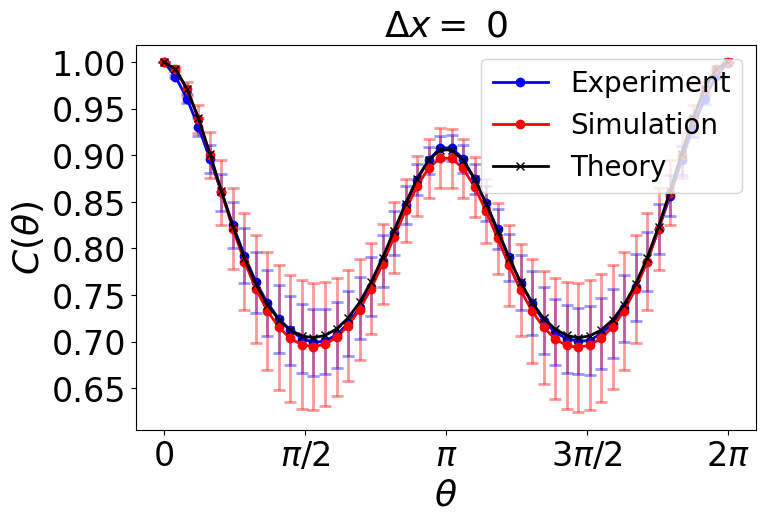

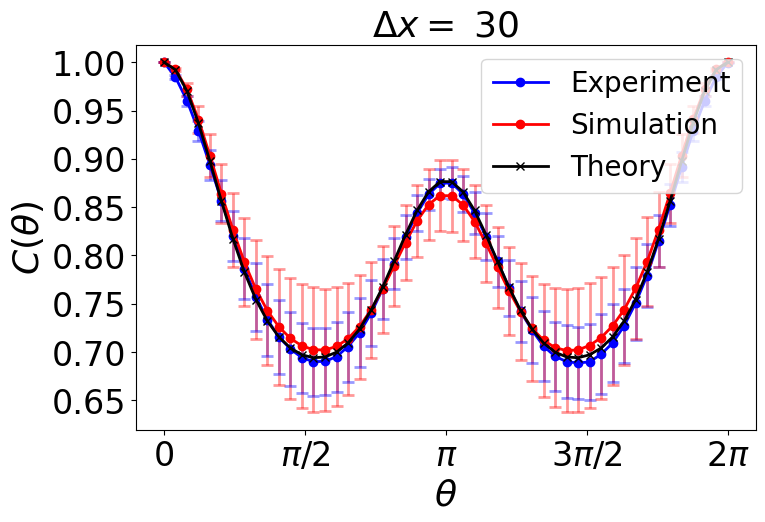

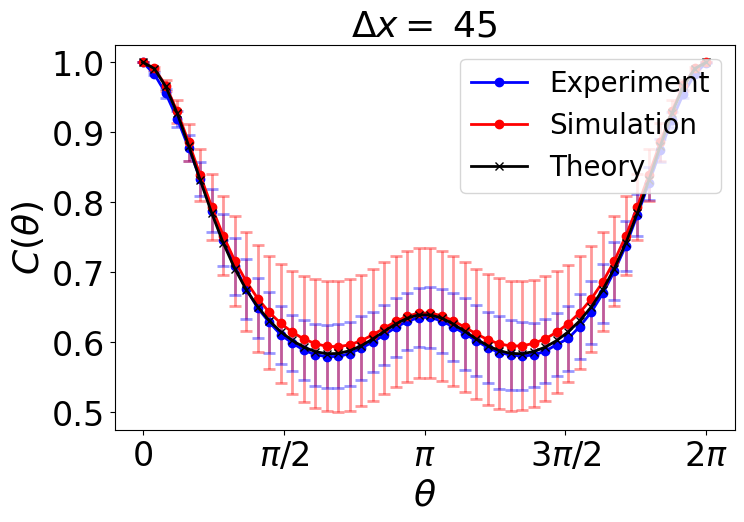

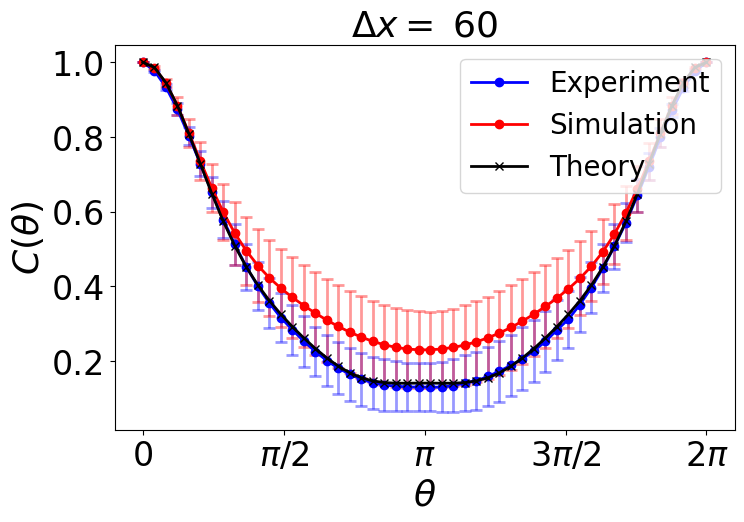

In [ ]:
for ind_deformation in range(len(deformation_indices)):
    show_RME_corr(show_error=True,
                  ind_deformation=ind_deformation, save_fig=True)

## B. $\Gamma_q$ as a function of the deformation

The values of $\Gamma_q$ are found by fitting the theoretical prediction
(Eq.4 of the main text)
to the experimental data.
They represent the azimuthal perturbation of the refractive index $\sum_q \Gamma_q\cos(q\phi)$


In [24]:
from matplotlib.ticker import ScalarFormatter

gammas = data["theo"]["gammas"]
# see caption of Fig.4
Gamma_tilde = std_max * gammas * k0 * dz

plt.figure(figsize=(12, 5))
for ind_q, q in enumerate(qs):
    plt.plot(
        Delta_x,
        gammas[:, ind_q],
        marker="o",
        label=rf"$\Gamma_{q}$",
        linewidth=2,
    )
plt.legend()
plt.ylabel(
    r"$\sigma_g^{max} \,(k l_z)\,  \, \Gamma_q $",
    fontsize=LABEL_SIZE,
    labelpad=20,
    rotation=90,
)
plt.xlabel(r"$\Delta x$ (in microns)", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.yticks(fontsize=TICK_SIZE)
plt.legend(fontsize=LEGEND_SIZE, loc="upper left")

# Use scientific notation for the Y-axis
ax = plt.gca()
ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
ax.yaxis.offsetText.set_fontsize(LEGEND_SIZE)

if SAVE_FIG:
    plt.savefig(
        image_path(f"Gamma_q.svg"),
        dpi=300,
    )

    


KeyError: 'theo'